# Challenge - Internal quality prediction of pears using NIR spectra

This challenge consists in a developing a deep learning model (neural network) or other type of machine learning model aimed at the prediction of two internal quality parameters of pears, namely the soluble solids content (SSC) usually refered to as brix, and firmness. The data consists of NIR raw (and preprocessed) spectra of pears (the independent variables X) and the corresponding values of SSC and firmness obtained from wet chemistry measurements (the target variables, Y). This is a regression problem because we want to predict a continuous variable (either brix or firmness).
The data set was used in the following publication: <br>

- Cruz et al 2021, *Nondestructive simultaneous prediction of internal browning disorder and quality attributes in ‘Rocha’ pear (Pyrus communis L.) using VIS-NIR spectroscopy*, Postharvest Biology and Technology, 111562, https://doi.org/10.1016/j.postharvbio.2021.111562.

Use the train data to develop your model and submit your predictions for the test data. The performance metric is the root mean squared error (RMSE) between the predicted and true values of the target variables. You can choose to predict only one of the target variables or both, individually or simultaneously. That is up to you.

#### **Submission**
**The predictions should be saved in a .csv file (one per target variable) before submission by email to dmpassos@ualg.pt. Attach your code and a brief description of the model you used.** <br>
The true values of the target variables for the test data are not provided and will be used to evaluate the performance of your model after submission.

## Import main libraries

In [1]:
from sys import stdout
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns 
from scipy.signal import savgol_filter
from scipy import stats


# from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler, RobustScaler
from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score , KFold, cross_val_predict
from sklearn.metrics import r2_score, make_scorer, explained_variance_score, root_mean_squared_error
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
#     cross_validate, StratifiedKFold


## Import the files in .csv format in the challenge_data folder. We can use Pandas to read the files.

**Files description**

The `x_train.csv`, `x_test.csv` contain the raw spectra (photon counts per channel) while the `x_2d_snv_train.csv` and `x_2d_snv_test.csv` contain a preprocessed (a.k.a. pre-treated) version of the spectra. The preprocessing applied was a smooth second derivative (Savitzky-Golay derivative) followed byt SNV (Standard Normal Variate). This type of preprocessing step in common in spectroscopy and helps to remove baseline effects in the spectra and to enhance spectral features. The first row in these files corresponds to the spectral feature number (that can be mapped to the wavelength) and the first column corresponds a code corresponding to the sample number. These matrices contain 3204 samples (rows) and 874 features (columns).

The `y_brix_train.csv` and `y_brix_test.csv` contain the target variable: **brix** (sugar content) of the samples. The first column corresponds to the sample number. \
The `y_firm_train.csv` and `y_firm_test.csv` contain the target variable: **firmness** of the samples. The first column corresponds to the sample number.\
These matrices contain 3204 samples (rows) and 1 feature (column).

In [43]:
## Path to the data folder
data_dir = 'challenge_data/'

## Import training data (raw spectra and pre-processed spectra)
x_train = pd.read_csv(data_dir + 'x_train.csv', index_col=0)
x_2d_snv_train = pd.read_csv(data_dir + 'x_2d_snv_train.csv', index_col=0)
## Import the target values to predict
brix_train = pd.read_csv(data_dir + 'y_brix_train.csv', index_col=0)
firm_train = pd.read_csv(data_dir + 'y_firm_train.csv', index_col=0)

## Import test data (raw spectra and pre-processed spectra) to create final predictions
x_test = pd.read_csv(data_dir + 'x_test.csv', index_col=0)
x_2d_snv_test = pd.read_csv(data_dir + 'x_2d_snv_test.csv', index_col=0)

## Import the wavelengths of the spectra (useful for plotting purposes)
wavelengths = pd.read_csv(data_dir + 'wavelengths.csv', index_col=None, names=['wavelengths'])

In [49]:
x_2d_snv_train = pd.read_csv(data_dir + 'x_2d_snv_train.csv', index_col=0)

In [44]:
x_2d_snv_train = np.array(x_2d_snv_train)
def normalize_01(df):
    return (df - df.min()) / (df.max() - df.min())
x_2d_snv_train1 = normalize_01(x_2d_snv_train)

Data visualization example

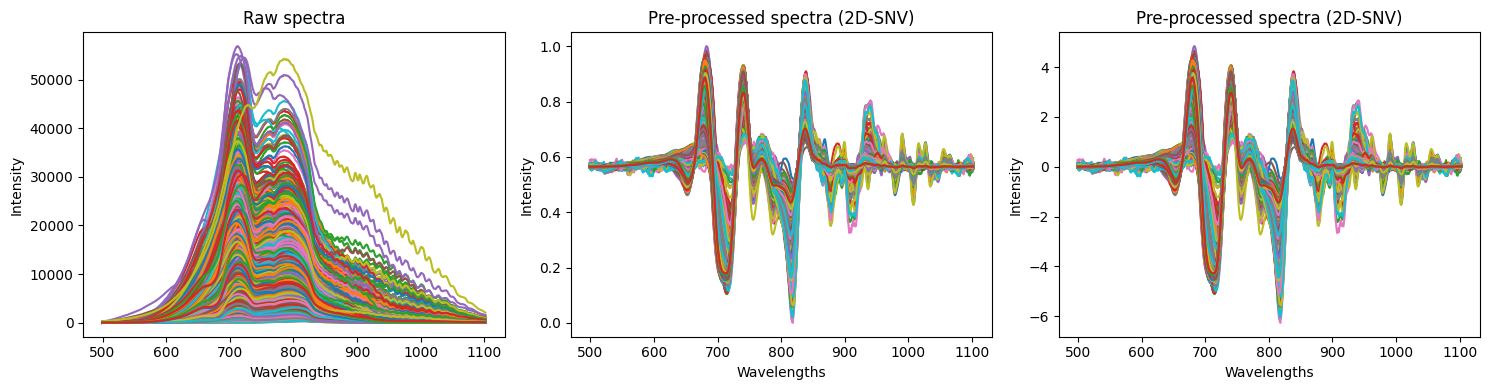

In [46]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(wavelengths, x_train.T)
plt.title('Raw spectra')
plt.xlabel('Wavelengths')
plt.ylabel('Intensity')
plt.subplot(1, 3,2 )
plt.plot(wavelengths, x_2d_snv_train1.T)
plt.title('Pre-processed spectra (2D-SNV)')
plt.xlabel('Wavelengths')
plt.ylabel('Intensity')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(wavelengths, x_2d_snv_train.T)
plt.title('Pre-processed spectra (2D-SNV)')
plt.xlabel('Wavelengths')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

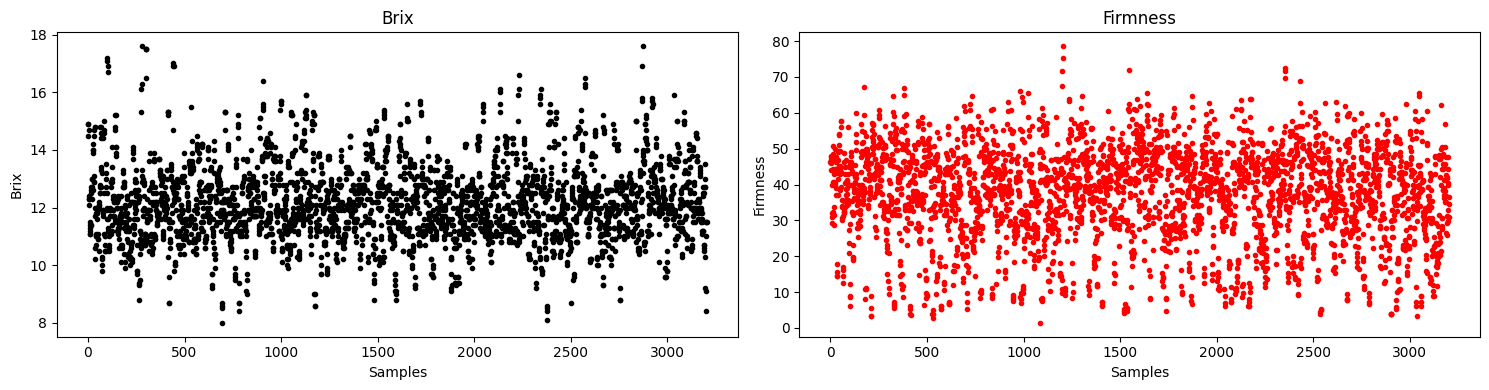

In [4]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(brix_train.values,'k.')
plt.title('Brix')
plt.xlabel('Samples')
plt.ylabel('Brix')
plt.subplot(1, 2, 2)
plt.plot(firm_train.values, 'r.')
plt.title('Firmness')
plt.xlabel('Samples')
plt.ylabel('Firmness')
plt.tight_layout()
plt.show()

## Examples of model training and prediction

It is advised to split the training data into two subsets: train and validation. The train subset is used to train the model and the validation subset is used to evaluate the model performance. This is a common practice in machine learning to avoid overfitting and for model hyperparameter tuning. In this case we will use 80% of the data for training and 20% for validation. 

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(x_2d_snv_train1)

5

In [57]:
np.sqrt(2) - np.sqrt(1)

0.41421356237309515

In [56]:
for train_index, test_index in kf.split(x_2d_snv_train1):
    print(len(test_index))

641
641
641
641
640
